# Задача классификации текстов
Задача классификации тексов весьма актуальна. Она встречается в различных сферах: классификация новостей, электронных книг по жанрам, отзывов в интернет магазине. Конкретно данная задача связана с идентификацией автора текста, по сути это выявление некоторой структуры в тексте, которая характеризует данного писателя. Навскидку, хорошее решение данной задачи с легкостью может быть перенесено на задачу поиска плагиата или парафраза. <br>
Сейчас существует множество моделей, с помощью которых данную задачу можно разрешить. Отдельно стоит выделить: <br>
* Логистическая (линейная) регрессия на мешке слов. Метод крайне прост, по сути все его части уже написаны и осталось только их собрать. Данный метод прекрасно работает например на классификации отзывов ( лично я писал данную задачу в рамках одного из курсов). Случайный лес или градиентный бустинг тоже подходят для данной задачи, однако это заведомо не является хорошим примером работы с разреженными данными большей размерности. В связи с тотальной нехваткой времени, я не буду приводить в качестве примера методы, которые не являются основным в моей работе. 
* Я решил отойти от стандартного подхода (по крайней мере я так считаю), и написать более оригинальную модель(с открытым кодом я таких не видел, хотя, быть может они есть). А именно, я использую LSTM модель, которую я использовал для генерации текста. Вся разница будет в том, что данная модель будет many-to-one (по классификации Андрея Корпатного). То есть принимать на вход выражение произвольной длины, а на выходе мы будем иметь единственный вектор из вероятностей фиксированной длины(в общем случае авторов может быть несколько).
![](img/many_to_one.jpg)
* Также существует применение сверточных нейронных сетей к текстам. Возможно, гибрид сверточной сети и lstm даст лучший результат. (в распозновании текста (optical character recognition), например, именно с этим связаны некоторые прорывы)

# Программа
Перейдем непосредственно к программе. <br> 
Язык: python 2.7<br>
Зависимости:<br>
theano <br>
lasagne <br>
cuda <br>
numpy <br>

# Данные
Все книги были скачаны с [сайта](http://royallib.com).
и представляют из себя: <br>
* Полное собрание сочинений в 20 томах. Л. Толстой (порядка 10 млн. символов)
* Множество различных книг, включающих русских писателей классиков (Пушкин, Тургенев).

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5105)


Поместим в corpora_T весь текст книг Льва Толстого, в corpora_o все остальное.

In [2]:
corpora_T = ""
for fname in os.listdir("Tolstoy"):    
    with open("Tolstoy/"+fname) as fin:
        text = fin.read().decode('cp1251')
        corpora_T += text.lower()
        n_test_T = len(text)
        
corpora_o = ""
for fname in os.listdir("Other"):    
    with open("Other/"+fname) as fin:
        text = fin.read().decode('cp1251')
        corpora_o += text.lower()
        n_test_o = len(text)

Заведем лист из всех уникальных символов. 

In [3]:
tokens = set(corpora_T + corpora_o)
tokens = list(tokens)
n_tokens=len(tokens)

In [4]:
n_tokens

119

Сопоставив каждому символу его номер перейдем от символьных последовательностей к числовым

In [5]:
token_to_id = {token:i for (i,token) in enumerate(tokens)}
id_to_token = {i:token for token,i in token_to_id.items()}

corpora_T_ids = np.array([token_to_id[symbol] for symbol in corpora_T])
corpora_o_ids = np.array([token_to_id[symbol] for symbol in corpora_o])

Ну и хочется иметь какой-то генератор батчейю Так как тексты имеют огромные размеры, то можно сделать его случайным. 

In [6]:
def sample_random_batches(source1, source2,  n_batches=10, seq_len=20):
    X_batch, y_batch = np.zeros((2 * n_batches, seq_len)), np.zeros(2 * n_batches)
    
    for i in xrange(n_batches):
        pos = np.random.randint(0, source1.size - seq_len)
        X_batch[2*i, :] = source1[pos:pos+seq_len]
        y_batch[2*i] =  1
        pos = np.random.randint(0, source2.size - seq_len)
        X_batch[2*i + 1, :] = source2[pos:pos+seq_len]
        y_batch[2*i + 1] = 0        
    return X_batch, y_batch

# Константы
В LSTM моделях приходится искуственно нормировать градиент. <br>
Также макропараметром является количество символов, на которые смотрит нейросеть. Опыт показывает, что на начальных стадиях следует учить модель на последовательностях небольшей длины, постепенно увеличивая длину последовательности.

In [7]:
seq_length = 60
grad_clip = 100 #max gradient norm 

# Модель


In [8]:
input_sequence = T.matrix('input sequence','int32')
target_y = T.vector("target_y",dtype='int64')

In [9]:
from lasagne.layers import *

In [10]:
input_layer = InputLayer(shape=(None, None),input_var=input_sequence)

nnet=EmbeddingLayer(input_layer, input_size=n_tokens, output_size=150)
nnet=LSTMLayer(nnet,num_units=100,nonlinearity=lasagne.nonlinearities.tanh,
                            grad_clipping=grad_clip, only_return_final=False)
nnet=LSTMLayer(nnet,num_units=100,nonlinearity=lasagne.nonlinearities.tanh,
                            grad_clipping=grad_clip, only_return_final=True)

nnet=DenseLayer(dropout(nnet, p=.3),1024)
output_layer=DenseLayer(nnet,2,nonlinearity=lasagne.nonlinearities.softmax)

In [11]:
weights = lasagne.layers.get_all_params(output_layer,trainable=True)
network_output = lasagne.layers.get_output(output_layer)
loss = lasagne.objectives.categorical_crossentropy(network_output,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(network_output,target_y).mean()
updates = lasagne.updates.adam(loss, weights)

# Компиляция theano функций

In [12]:
train_fun = theano.function([input_sequence, target_y], [loss,accuracy],  updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_sequence,target_y],accuracy, allow_input_downcast=True)

# Обучение
Состоит из множества стадий по 5 эпох. На каждой последующей стадии, количество символов увеличивается. То есть для  достижения более высокого результата ищутся более сложные закономерности в последовательности. Я считаю, что такой подход весьма логичен. 


In [13]:
loss = []
acc_tr = []
acc_ts = []

In [ ]:
import time
N_test = 30
num_epochs = 5
batch_size = 5 
batches_per_epoch = 10000
for seq_length in [40, 100, 200]:
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for _ in xrange(batches_per_epoch):
            inputs, targets = sample_random_batches(corpora_T_ids[:-n_test_T],corpora_o_ids[:-n_test_T], batch_size,seq_length)
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1
        test_acc = 0
        test_batches = 0
        for _ in xrange(N_test):
            inputs, targets = sample_random_batches(corpora_T_ids[-n_test_T:],corpora_o_ids[-n_test_T:], batch_size,seq_length)
            test_acc += accuracy_fun(inputs, targets)
            test_batches += 1
            
        loss.append(train_err / train_batches)
        acc_tr.append(train_acc / train_batches)
        acc_ts.append(test_acc / train_batches)
        
        print("Sequence length {} epoch {} of {} took {:.3f}s".format(
                seq_length, epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  test accuracy:\t\t{:.2f} %".format(
            test_acc / test_batches * 100))

Sequence length 40 epoch 1 of 5 took 193.302s
  training loss (in-iteration):		0.682762
  train accuracy:		54.32 %
  test accuracy:		51.00 %
Sequence length 40 epoch 2 of 5 took 201.766s
  training loss (in-iteration):		0.654018
  train accuracy:		60.60 %
  test accuracy:		56.00 %
Sequence length 40 epoch 3 of 5 took 193.351s
  training loss (in-iteration):		0.636048
  train accuracy:		62.73 %
  test accuracy:		58.33 %
Sequence length 40 epoch 4 of 5 took 189.752s
  training loss (in-iteration):		0.622791
  train accuracy:		64.22 %
  test accuracy:		59.33 %
Sequence length 40 epoch 5 of 5 took 200.440s
  training loss (in-iteration):		0.610652
  train accuracy:		65.40 %
  test accuracy:		59.33 %
Sequence length 100 epoch 1 of 5 took 489.633s
  training loss (in-iteration):		0.507725
  train accuracy:		74.69 %
  test accuracy:		67.00 %
Sequence length 100 epoch 2 of 5 took 410.745s
  training loss (in-iteration):		0.489934
  train accuracy:		75.79 %
  test accuracy:		71.33 %
Sequence le

# Сходимость

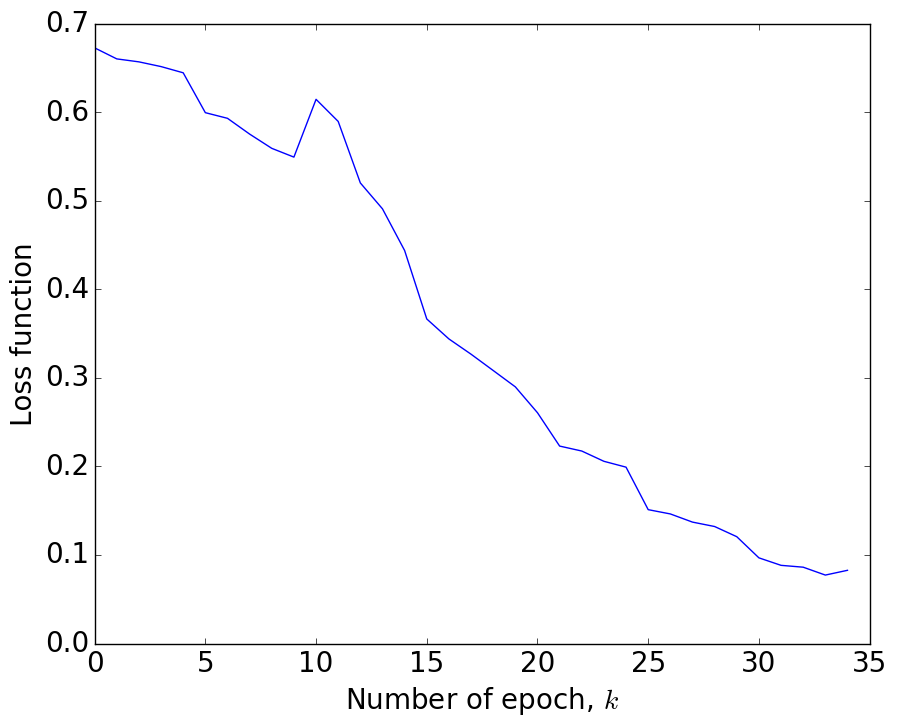

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(loss)
plt.xlabel(r"Number of epoch, $k$", fontsize=20)
plt.ylabel(r"Loss function", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)

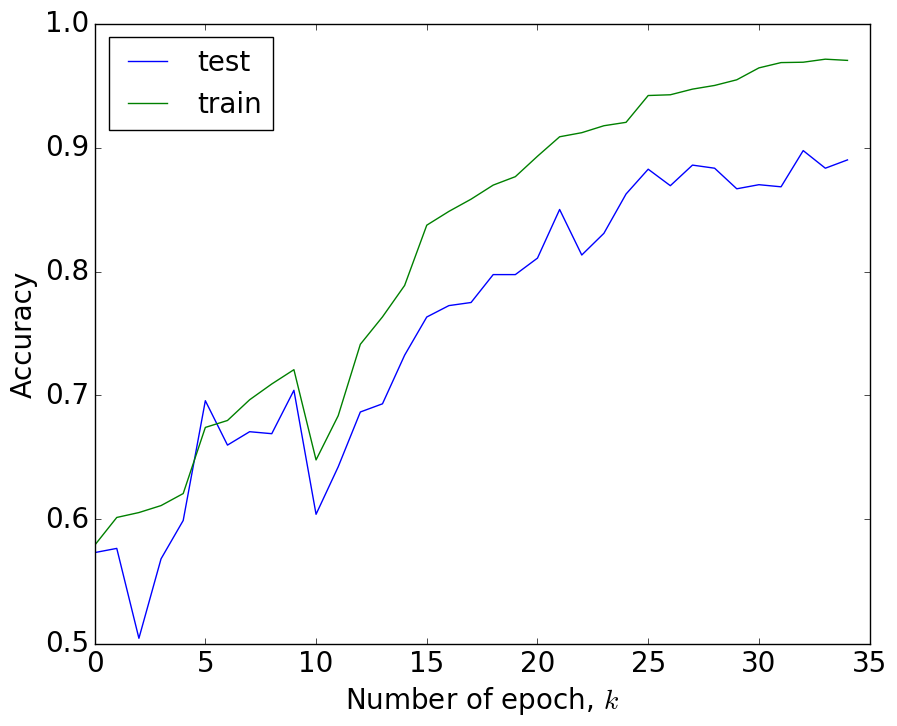

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(acc_ts, label = r"test")
plt.plot(acc_tr, label = r"train")
plt.xlabel(r"Number of epoch, $k$", fontsize=20)
plt.ylabel(r"Accuracy", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)

In [15]:
test_acc = 0
test_batches = 0
for _ in xrange(100):
    inputs, targets = sample_random_batches(corpora_T_ids[-n_test_T:],corpora_o_ids[-n_test_T:], batch_size,seq_length)
    test_acc += accuracy_fun(inputs, targets)
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		89.42 %


# Что можно еще сделать
На вскидку приходит идея распозновать последовательности не посимвольно,  а по словам(word2vec и все такое). Ну и в заключении хочется заметить, что полученная модель очень общая и с легкостью перенесется на ряд задач (прогнозирование временных рядов, идентификация автора рукописного текста). 